In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import pyinterp
import pyinterp.backends.xarray

import mitequinox.plot as pl
import mitequinox.utils as ut
from mitequinox.parcels import store_parquet

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6005100.datarmor0/parcels-502027/libparcels_random_149ea100-9d24-4e0c-aa97-666db2c6fda9.so


In [3]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=4, cores=4)
    #w = cluster.scale(jobs=15) # heavier data processing
    w = cluster.scale(jobs=10)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster(n_workers=2, threads_per_worker=1)
    client = Client(cluster)
    client

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34794 instead
  warnings.warn(


In [54]:
client

Client Scheduler: tcp://127.0.0.1:59942 Dashboard: http://127.0.0.1:34794/status,Cluster Workers: 2 Cores: 2 Memory: 100.00 GiB


# load data

In [55]:
site = "california"
site_dir = os.path.join(ut.diag_dir, "regional_"+site)
site_dir

'/home/datawork-lops-osi/equinox/mit4320/diags/regional_california'

In [56]:
#ds = xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
df = dd.read_parquet(os.path.join(site_dir, "llc_parcels_time_mean"))
df = df.repartition(npartitions=500).persist()
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,zonal_velocity_mean,temperature_mean,meridional_velocity_mean,salinity_mean
time,,,,,,,,,,,,,,
2011-11-15,38000612,43.223770,-152.822922,0.0,0.0,0.0,0.0,0.0,0.0,0.301963,0.111188,11.264963,-0.047701,32.847267
2011-11-15,38000637,43.223770,-151.781250,0.0,0.0,0.0,0.0,0.0,0.0,0.289056,0.094942,11.465209,0.017127,32.781781
2011-11-15,38000661,42.514122,-150.739578,0.0,0.0,0.0,0.0,0.0,0.0,0.323792,0.107724,12.161278,-0.024647,32.890323
2011-11-15,38000685,41.797028,-149.697922,0.0,0.0,0.0,0.0,0.0,0.0,0.352433,0.089004,13.222504,-0.016940,33.018796
2011-11-15,38000692,46.660358,-149.697922,0.0,0.0,0.0,0.0,0.0,0.0,0.242264,0.074070,8.888128,0.006434,32.550297


In [57]:
def interp(df):

    if hasattr(df, "time"):
        t = df["time"].unique()[0]
    elif df.index.name == "time":
        # dask dataframe
        t = df.index.unique()[0]
    elif hasattr(df, "name"):
        # when mapped after groupby
        t = df.name
    else:
        assert False, "Cannot find float id"

    diag = load_instantaneous_diagnostic(t)

    # interpolate on tracks
    for v in diag:
        df[v] = interp_snapshot(diag[v], df)

    return df
    

def load_instantaneous_diagnostic(t):
    
    # overwrite default with threaded scheduler    
    # "single-threaded"
    import dask
    
    with dask.config.set(scheduler="single-threaded"):

        # load data
        # not properly chunked
        #ds = xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
        #ds = xr.open_zarr(os.path.join(ut.ref_data_dir, "SSU.zarr") ).rename({"i_g": "i"})
        #ds = ds.sel(face=10)
        #grd = (xr.open_zarr(os.path.join(ut.ref_data_dir, "grid.zarr") )[["XC", "YC"]]
        #       .sel(face=10)
        #       .rename({"XC": "lon", "YC": "lat"})
        #      )
        #ds = xr.merge([ds, grd])
        #ds = ds.sel(time=t, method="nearest")
        
        #diag_dir = '/home/datawork-lops-osi/equinox/mit4320/diags/'
        ds = xr.merge([(xr.open_zarr(os.path.join(ut.diag_dir,"dEta_"+_dir+"_california.zarr"))
                        .sel(time=t, method="nearest")
                        .rename({"dEta_"+_dir+"_california": "dEta_"+_dir})
                        .rename({"XC": "lon", "YC": "lat"})
                       )
                       for _dir in ["dx", "dy"]]
                     )
        
        # build diagnostic
        #diag = 0.5*(ds["meridional_velocity"]**2+ds["zonal_velocity"]**2)        
        #diag = ds["SSU"].compute()
        diag = ds.compute()
         
    return diag

def interp_snapshot(da, df):

    # prepare interpolator
    mesh = pyinterp.RTree()
    lons = da.lon
    lats = da.lat
    mesh.packing(
        np.vstack((lons.values.flatten(), lats.values.flatten())).T,
        da.values.flatten(),
    )

    # target positions
    lon = df["lon"].values
    lat = df["lat"].values

    out, neighbors = mesh.inverse_distance_weighting(
        np.vstack((lon, lat)).T,
        within=True,  # Extrapolation is forbidden
        radius=55000,  # In a radius of 5.5 Km
        k=8,  # We are looking for at most 8 neighbours
        num_threads=0,
    )
    
    return out

In [58]:
#_df = df.get_partition(0).compute().iloc[:1000, :]
#_df = df.get_partition(0)
_df = df

out = _df.groupby(_df.index).apply(interp).persist()

/dev/shm/pbs.6005100.datarmor0/ipykernel_48781/3337645608.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  out = _df.groupby(_df.index).apply(interp).persist()


In [59]:
out.head()

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [ ]:
# save
store_parquet(ut.diag_dir, out, name="california_parcels_time_mean_gradp", overwrite=True)

____
# Reload and make a simple comparison


In [60]:
df = dd.read_parquet(os.path.join(ut.diag_dir, "california_parcels_time_mean_gradp"))
df = df.compute()
df = df.dropna()

# add geostrophic estimate
g=9.81
g=1  # tmp !!!
f = ut.coriolis(df["lat"])
df["zonal_velocity_geo"] = -g*df["dEta_dy"]/f
df

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/process.py", line 192, in _run
    target(*args, **kwargs)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/nanny.py", line 799, in _run
    loop.run_sync(do_stop)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home1/datahom

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [32]:
ds = (xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
      .sel(time="2012-03-01 00:00:00")
      .set_coords(["lon", "lat"])
     ).persist()
ds

<xarray.Dataset>
Dimensions:              (i: 636, j: 480)
Coordinates:
    Depth                (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    face                 int64 ...
  * i                    (i) int64 2765 2766 2767 2768 ... 3397 3398 3399 3400
  * j                    (j) int64 0 1 2 3 4 5 6 ... 473 474 475 476 477 478 479
    lat                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    lon                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    niter                int64 dask.array<chunksize=(), meta=np.ndarray>
    time                 datetime64[ns] 2012-03-01
Data variables:
    meridional_velocity  (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    zonal_velocity       (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>

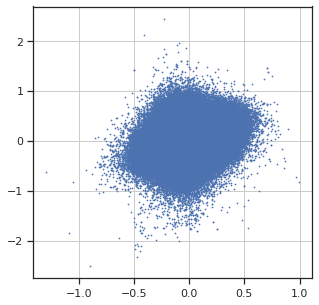

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter( df["zonal_velocity"], df["zonal_velocity_geo"], s=.5)
ax.grid()

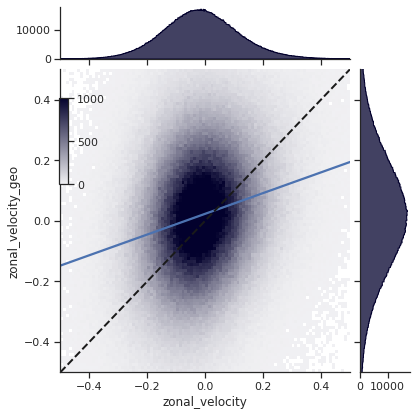

In [34]:
import seaborn as sns
sns.set_theme(style="ticks")

lims = (-.5, .5)

_data = dict(data=df, x="zonal_velocity", y="zonal_velocity_geo")

_g = sns.JointGrid(**_data,
                  marginal_ticks=True,
                  xlim=lims, ylim=lims,
                 )

# Create an inset legend for the histogram colorbar
cax = _g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
_g.plot_joint(
    sns.histplot, 
    binwidth = (.01, .01),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
sns.regplot(**_data, ax=_g.ax_joint, scatter=False)
_g.ax_joint.plot(lims, lims, color="k", ls="--", linewidth=2)

_g.plot_marginals(sns.histplot, element="step", color="#03012d")

## Check amplitude of dEta_dy

In [35]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def get_proj(extent):
    lon = (extent[0]+extent[1])*.5
    lat = (extent[2]+extent[3])*.5
    return ccrs.Orthographic(central_longitude=lon, 
                     central_latitude=lat, 
                     globe=None,
                    )

extent = [-128, -123, 33, 38]
projection = get_proj(extent)

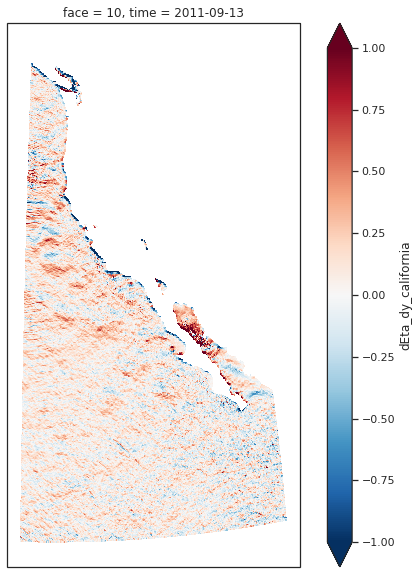

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=projection))

_ds = xr.open_zarr(os.path.join(ut.diag_dir,"dEta_dy_california.zarr")).isel(time=0)

(-g*_ds["dEta_dy_california"]/f.mean()).plot(ax=ax, x="XC", y="YC", vmin=-1, vmax=1, cmap="RdBu_r", transform=ccrs.PlateCarree(),)

# low pass filtering

In [37]:
from scipy import signal
import mitequinox.sigp as sp

In [38]:
dt = 1/24 # in days
T=10 # filter length in days

h = sp.generate_filter("subdiurnal", T=T, dt=dt)
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


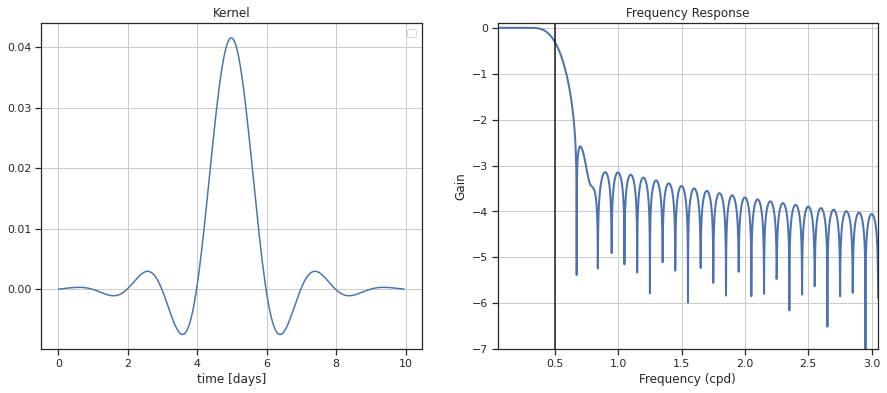

In [39]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel("time [days]")
ax.set_title("Kernel")
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(0.5, color="k")
ax.set_xlabel("Frequency (cpd)")
ax.set_ylabel("Gain")
ax.set_title("Frequency Response")
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

# apply filter to drifter data


In [42]:
def filter_data(x, h, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    # fill blanks in time series with NaN
    x = x.resample("1H").mean()
    if x.index.size<3*h.size:
        return x*np.NaN
    
    if hilbert:
        f = lambda x: signal.hilbert(signal.filtfilt(h, [1], x))
    else:
        f = lambda x: signal.filtfilt(h, [1], x)
    return x.apply(f, axis=0)

In [47]:
df_low = df.groupby("trajectory").apply(filter_data, h)

/dev/shm/pbs.6005100.datarmor0/ipykernel_48781/2035329794.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_low = df.groupby("trajectory").apply(filter_data, h)


ValueError: Could not interpret value `zonal_velocity_geo` for parameter `y`

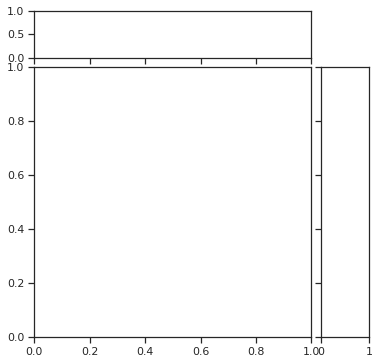

In [48]:
import seaborn as sns
sns.set_theme(style="ticks")

lims = (-.5, .5)

_data = dict(data=df_low, x="zonal_velocity", y="zonal_velocity_geo")

_g = sns.JointGrid(**_data,
                  marginal_ticks=True,
                  xlim=lims, ylim=lims,
                 )

# Create an inset legend for the histogram colorbar
cax = _g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
_g.plot_joint(
    sns.histplot, 
    binwidth = (.01, .01),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
sns.regplot(**_data, ax=_g.ax_joint, scatter=False)
_g.ax_joint.plot(lims, lims, color="k", ls="--", linewidth=2)

_g.plot_marginals(sns.histplot, element="step", color="#03012d")

In [62]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
